# Inferential Analysis



In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy import stats


import psutil
import warnings
from sinfo import sinfo

warnings.filterwarnings("ignore")
plt.rcdefaults()

In [ ]:
class WinsorizedMeanCalculator:
    def __init__(self, lower_percentile=0.05, upper_percentile=0.95):
        """
            Winsorized Mean (5%)
            ---
            Args:
                lower_percentile=0.05
                upper_percentile=0.95
            ---
            The k% winsorized mean is obtained by calculating the 
            arithmetic mean after replacing the k% of the smallest values 
            by the smallest value of the remaining values and the k% of the 
            largest values by the largest value of the remaining values.
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def winsorize(self, data):
        lower_limit = np.percentile(data, self.lower_percentile * 100)
        upper_limit = np.percentile(data, self.upper_percentile * 100)

        # Replace extreme values with the adjacent limits
        data = np.where(data < lower_limit, lower_limit, data)
        data = np.where(data > upper_limit, upper_limit, data)

        return data

    def calcu_winsor_mean(self, column):
        winsorized_data = self.winsorize(column)
        return np.mean(winsorized_data)

winsor = WinsorizedMeanCalculator()

def range(col):
    return col.max() - col.min()

def ksfunc(col):
    return stats.kstest(col, stats.norm.cdf,
                        args=(col.mean(), col.std()))

def cdv(col):
    """
        Coefficient of Variation Centered on the Mean.
        ---
        (std / mean) * 100
        ---
        Reasonable dispersion is associated with coefficients of variation 
        less than 50. Coefficients of variation greater than 50 indicate a 
        lot of dispersion. Coefficients greater than 100 are generally 
        indicative of strong anomalies in the data.
    """
    return (col.std() / abs(col.mean())) * 100

def trimean(series):
    """
        BESA (best easy systematic average)
        ---
        (Q1 + 2*Q2 + Q3) / 4
        ---
        Highly robust central tendency statistic
    """
    Q1 = series.quantile(0.25)
    median = series.median()
    Q3 = series.quantile(0.75)
    return (Q1 + 2 * median + Q3) / 4


In [2]:
# Storing path
path = Path("../data/ifood_cleaned.csv")

# Read CSV with pandas
data = pd.read_csv(path)

# Read columns dtypes
with open('../data/cleaned_dtypes.json', 'r') as f:
    data_types = json.load(f)

data = data.astype(data_types)

In [3]:
data["MntTotal_cat"], intervals = pd.cut(data["MntSpentTotal"], 6, 
                                         precision=0, retbins=True)

temp, first_int = pd.cut(np.arange(2, 426), 5, retbins=True)
bins = list(first_int) + list(intervals[2:])

data["MntTotal_cat"], intervals = pd.cut(data["MntSpentTotal"], bins, 
                                         precision=0, right=False, 
                                         retbins=True, ordered=True)

data["Recency_cat"] = data["Recency_cat"].cat.as_ordered()
data["Age_cat"] = data["Age_cat"].cat.as_ordered()

data["Education"] = data["Education"].cat.reorder_categories(["Basic", 
                                                              "Graduation", 
                                                              "2n Cycle", 
                                                              "Master", 
                                                              "PhD"], 
                                                              ordered=True)

data["Income_cat"] = data["Income_cat"].cat\
    .reorder_categories(['D1', 'D2', 'D3', 'D4', 'D5', 
                         'D6', 'D7', 'D10'], ordered=True)

## Correlations

In [ ]:
int_cols = ["Year_Old", "Income", "Recency", "MntSpentTotal", "MntWines", 
            "MntFruits", "MntMeatProducts", "MntFishProducts",
            "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", 
            "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",
            "ChildrenHome"]


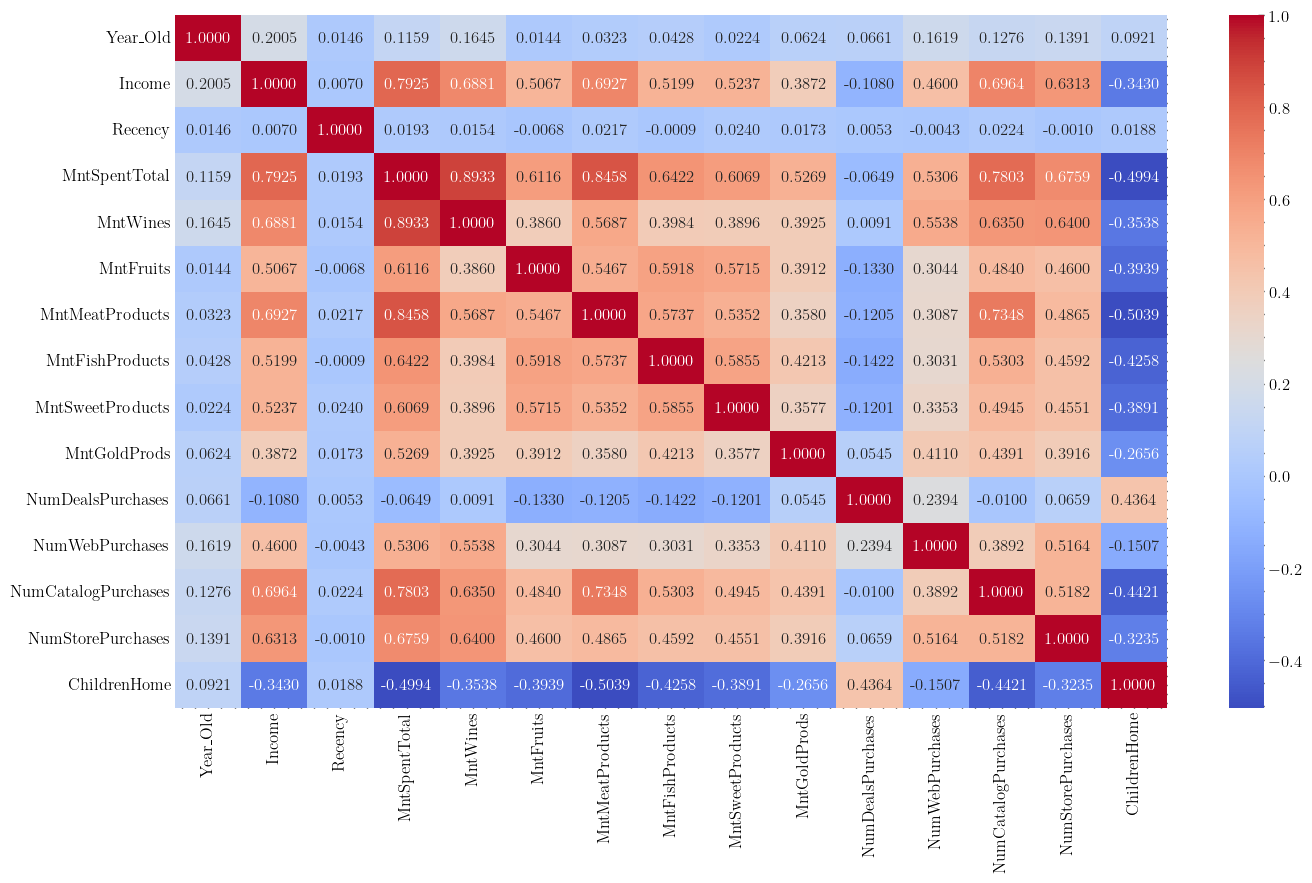

In [6]:
corr_matrix = data[int_cols].corr()

with plt.style.context(["seaborn-v0_8-colorblind",
                   "./mplstyle/basic.mplstyle",
                   "./mplstyle/scatter.mplstyle",
                   ]):
    
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".4f")
    plt.show()

Pearson Correlation between 'MntSpentTotal' and 'Income'. 
	r = 0.7925


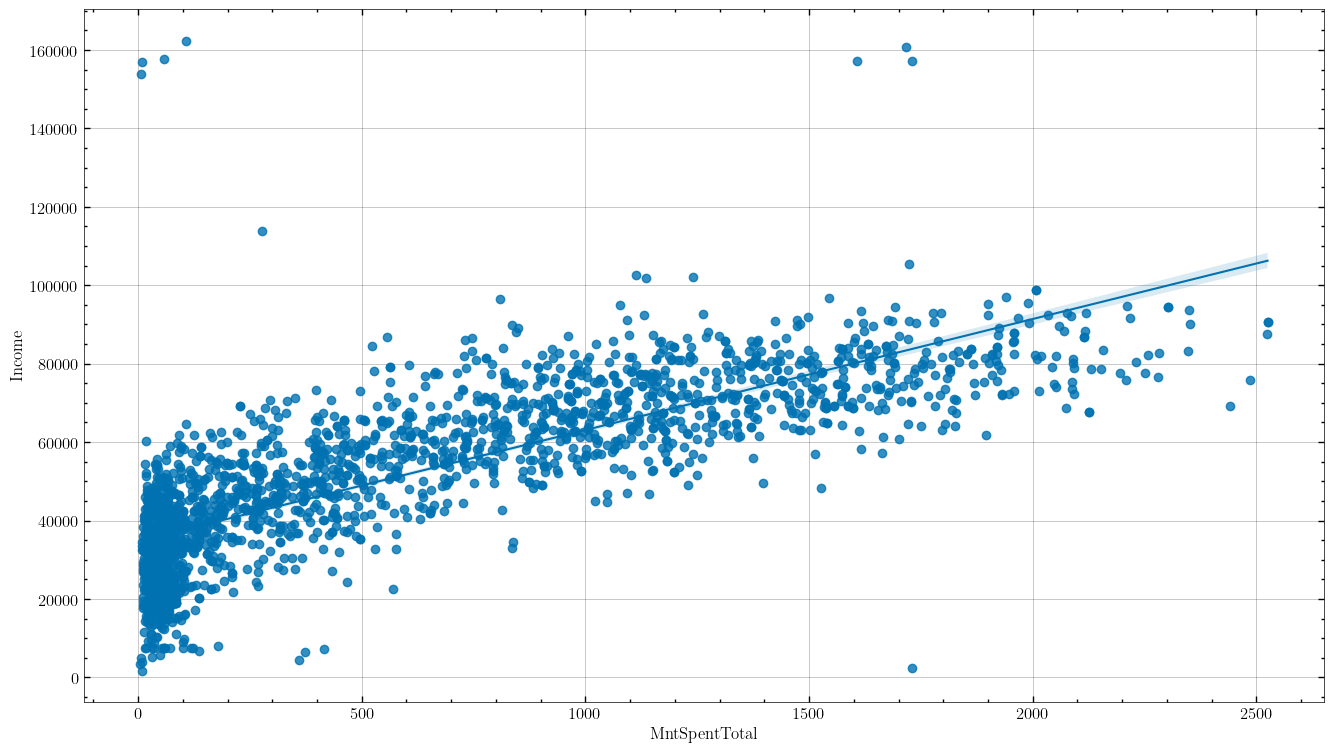

In [ ]:
corr_coef, p_value = stats.pearsonr(data["MntSpentTotal"], data["Income"])
print(f"Pearson Correlation between 'MntSpentTotal' and 'Income'. ",
      f"\n\tr = {corr_coef:.4f}", sep=''
      )

with plt.style.context(["seaborn-v0_8-colorblind",
                   "./mplstyle/basic.mplstyle",
                   "./mplstyle/scatter.mplstyle",
                   ]):

    plot = sns.regplot(x="MntSpentTotal", y="Income", data=data)
    plt.show();